# McKinney Chapter 10 - Practice - Sec 04

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## Announcements

1. Please join your project group today. Otherwise, I will randomly assign you to a group tonight.
2. Please vote for students' choice topics.
3. Please complete a week-5 survey; see the announcement on Canvas.

## Five-Minute Review

We will focus on 3 topics from chapter 10 of McKinney:

1. *GroupBy Mechanics:* We will use the `.groupby()` method to perform "split-apply-combine" calculations in pandas, which let us aggregate data by one of more columns or indexes.
2. *Data Aggregation:* We will combine optimized methods, like `.count()`, `.sum()`, `.mean()`, etc., with `.groupby()` to quickly aggregate data. We will combine the `.agg()` or `.aggregate()` method with `.groupby()` when we want to apply more than one aggregation function.
3. *Pivot Tables:* We can use the `.pivot_table()` method to aggregate data with a syntax similar to Excel’s pivot tables. We can almost always get the same output with the `.groupby()`, `.agg()`, and `.unstack()` methods.

## Practice

### Replicate the following `.pivot_table()` output with `.groupby()`

In [3]:
ind = (
    yf.download(
        tickers='^GSPC ^DJI ^IXIC ^FTSE ^N225 ^HSI',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
    .stack(future_stack=True)
)

[*********************100%***********************]  6 of 6 completed

::: {.callout-tip}

I learned after class that `pd.Grouper()` now has a `level` argument, too!
We do not have to reset a data frame index just to use `pd.Grouper()`!

:::

In [4]:
# Filter rows from 2015 onward
# Then pivot the 'ind' DataFrame so that:
#   - 'Close' values are aggregated
#   - Rows (index) are grouped yearly by 'Date' via pd.Grouper(...)
#   - Columns are broken out by 'Ticker'
#   - Both the 'min' and 'max' of 'Close' are calculated for each Ticker-year
# NOTE: pd.Grouper(level='Date', freq='YE') groups rows by the 'Date' index, 
#       rolling them up to the 'Year-End' frequency.
a = (
    ind
    .loc['2015':]
    .pivot_table(
        values='Close',
        index=pd.Grouper(level='Date', freq='YE'),
        columns='Ticker',
        aggfunc=['min', 'max']
    )
)

In [5]:
a.head()

min                                                      \
Ticker           ^DJI     ^FTSE     ^GSPC       ^HSI     ^IXIC      ^N225   
Date                                                                        
2015-12-31 15666.4404 5874.1001 1867.6100 20556.5996 4506.4902 16795.9609   
2016-12-31 15660.1797 5537.0000 1829.0800 18319.5801 4266.8398 14952.0195   
2017-12-31 19732.4004 7099.2002 2257.8301 22134.4707 5429.0801 18335.6309   
2018-12-31 21792.1992 6584.7002 2351.1001 24585.5293 6192.9199 19155.7402   
2019-12-31 22686.2207 6692.7002 2447.8899 25064.3594 6463.5000 19561.9609   

                  max                                                      
Ticker           ^DJI     ^FTSE     ^GSPC       ^HSI     ^IXIC      ^N225  
Date                                                                       
2015-12-31 18312.3906 7104.0000 2130.8201 28442.7500 5218.8599 20868.0293  
2016-12-31 19974.6191 7142.7998 2271.7200 24099.6992 5487.4399 19494.5293  
2017-12-31 24837.5098 7687.7998 2690.1599 30003.4902 6994.7598 22939.1797  
2018-12-31 26828.3906 7877.5000 2930.7500 33154.1211 8109.6899 24270.6191  
2019-12-31 28645.2598 7686.6001 3240.0200 30157.4902 9022.3896 24066.1191

In [6]:
# Filter rows from 2015 onward.
# Group by both:
#    1) Year-end frequency of the 'Date' index (pd.Grouper(level='Date', freq='YE')), and
#    2) 'Ticker'.
# Then select the 'Close' column from each group and aggregate by taking
# the 'min' and 'max'. Finally, use .unstack() to move 'Ticker' back to columns.
b = (
    ind
    .loc['2015':]
    .groupby([pd.Grouper(level='Date', freq='YE'), 'Ticker'])
    ['Close']
    .agg(['min', 'max'])
    .unstack()
)

In [7]:
a.equals(b)

True

In [8]:
np.allclose(a, b)

True

In [9]:
(a == b).all().all()

np.True_

### Calulate the mean and standard deviation of returns by ticker for the MATANA (MSFT, AAPL, TSLA, AMZN, NVDA, and GOOG) stocks

Consider only dates with complete returns data.
Try this calculation with wide and long data frames, and confirm your results are the same.

In [10]:
matana = (
    yf.download(
        tickers='MSFT AAPL TSLA AMZN NVDA GOOG',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

[*********************100%***********************]  6 of 6 completed

In [11]:
columns = pd.MultiIndex.from_product([['Return'], matana['Adj Close'].columns])
matana[columns] = matana['Adj Close'].pct_change()

In [12]:
matana['Return'].dropna().agg(['mean', 'std'])

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
mean,0.0011,0.0012,0.0009,0.0010,0.0021,0.0021
std,0.0175,0.0205,0.0173,0.0162,0.0288,0.0361


*Homework! Re-do this aggregation with *annualized* means and volatilities!*

We have (at least) two options here.

1. Write functions that calculate annualized means and volatilities, say `ann_mean()` and `ann_std()`
2. Use lambda (anonymous functions), then rename the rows

First, here is the "write functions" solution.
We do not need to provide userr-written function names in quotes.

In [13]:
def ann_mean(x, ann_fac=252):
    return ann_fac * x.mean()

In [14]:
def ann_std(x, ann_fac=np.sqrt(252)):
    return ann_fac * x.std()

In [15]:
a = matana['Return'].agg([ann_mean, ann_std])
a

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
ann_mean,0.2755,0.4335,0.2580,0.2830,0.4938,0.5343
ann_std,0.4408,0.5585,0.3061,0.3337,0.6004,0.5739


Second, here is the "lambda functions" solution.

In [16]:
b = matana['Return'].agg([lambda x: 252*x.mean(), lambda x: np.sqrt(252)*x.std()])
b.index = ['Mean', 'Volatility']
b

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
Mean,0.2755,0.4335,0.2580,0.2830,0.4938,0.5343
Volatility,0.4408,0.5585,0.3061,0.3337,0.6004,0.5739


In [17]:
np.allclose(a=a, b=b)

True

(These values differ just enough that we have to complete the fuzzy equality of `np.allclose()` instead of the exact equality of `.equals()`.)

### Calculate the mean and standard deviation of returns and the maximum of closing prices by ticker for the MATANA stocks

We have to reshape our data first, because the `.agg()` method does not work well with column multi-indexes.
The `.rename_axis()` method is optional, but I prefer to name my axes to simplify later stacking and unstacking.

In [18]:
a = (
    matana
    .stack(future_stack=True)
    .groupby(level='Ticker')
    .agg({
        'Return': ['mean', 'std'],
        'Close': 'max'
    })
    .rename_axis(columns=['Variable', 'Statistic'])
)
a

Variable  Return           Close
Statistic   mean    std      max
Ticker                          
AAPL      0.0011 0.0278 259.0200
AMZN      0.0017 0.0352 242.0600
GOOG      0.0010 0.0193 207.7100
MSFT      0.0011 0.0210 467.5600
NVDA      0.0020 0.0378 149.4300
TSLA      0.0021 0.0361 479.8600

We can do the same operation with `.pivot_table()`.

In [19]:
b = (
    matana
    .stack(future_stack=True)
    .pivot_table(
        index='Ticker',
        aggfunc={
        'Return': ['mean', 'std'],
        'Close': 'max'
    }
))
b

Price     Close Return       
            max   mean    std
Ticker                       
AAPL   259.0200 0.0011 0.0278
AMZN   242.0600 0.0017 0.0352
GOOG   207.7100 0.0010 0.0193
MSFT   467.5600 0.0011 0.0210
NVDA   149.4300 0.0020 0.0378
TSLA   479.8600 0.0021 0.0361

The column orders differ between `.agg()` and `.pivot_table()` solutions, but the values are the same.

In [20]:
a[['Close', 'Return']].equals(b[['Close', 'Return']])

True

### Calculate monthly means and volatilities for SPY and GOOG returns

In [21]:
spy_goog = (
    yf.download(
        tickers='SPY GOOG',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

spy_goog

Price      Adj Close             Close              High               Low  \
Ticker          GOOG      SPY     GOOG      SPY     GOOG      SPY     GOOG   
Date                                                                         
1993-01-29       NaN  24.5261      NaN  43.9375      NaN  43.9688      NaN   
1993-02-01       NaN  24.7005      NaN  44.2500      NaN  44.2500      NaN   
1993-02-02       NaN  24.7528      NaN  44.3438      NaN  44.3750      NaN   
1993-02-03       NaN  25.0145      NaN  44.8125      NaN  44.8438      NaN   
1993-02-04       NaN  25.1192      NaN  45.0000      NaN  45.0938      NaN   
...              ...      ...      ...      ...      ...      ...      ...   
2025-02-07  187.1400 600.7700 187.1400 600.7700 193.0150 608.1300 185.1000   
2025-02-10  188.2000 604.8500 188.2000 604.8500 189.9900 605.5000 187.6100   
2025-02-11  187.0700 605.3100 187.0700 605.3100 188.8000 605.8600 186.0800   
2025-02-12  185.4300 603.3600 185.4300 603.3600 186.8300 604.5500 183.6300   
2025-02-13  187.8800 609.7300 187.8800 609.7300 187.9900 609.9400 184.8800   

Price                   Open                 Volume            
Ticker          SPY     GOOG      SPY          GOOG       SPY  
Date                                                           
1993-01-29  43.7500      NaN  43.9688           NaN   1003200  
1993-02-01  43.9688      NaN  43.9688           NaN    480500  
1993-02-02  44.1250      NaN  44.2188           NaN    201300  
1993-02-03  44.3750      NaN  44.4062           NaN    529400  
1993-02-04  44.4688      NaN  44.9688           NaN    531500  
...             ...      ...      ...           ...       ...  
2025-02-07 600.0500 192.7400 606.8900 29565700.0000  50788500  
2025-02-10 602.7400 189.0600 604.0300 16606000.0000  26048700  
2025-02-11 602.4300 186.8350 602.5500 13028100.0000  30056700  
2025-02-12 598.5100 185.2300 599.2000 17632300.0000  45076100  
2025-02-13 603.2000 185.9300 604.4800 12729300.0000  40921300  

[8067 rows x 12 columns]

In [22]:
spy_goog_m = (
    spy_goog
    ['Adj Close']
    .pct_change()
    .groupby(pd.Grouper(level='Date', freq='ME'))
    .agg(['mean', 'std'])
    .dropna(how='all')
    .rename_axis(columns=['Ticker', 'Statistic'])
)

spy_goog_m

Ticker        GOOG            SPY       
Statistic     mean    std    mean    std
Date                                    
1993-02-28     NaN    NaN  0.0006 0.0080
1993-03-31     NaN    NaN  0.0010 0.0071
1993-04-30     NaN    NaN -0.0012 0.0074
1993-05-31     NaN    NaN  0.0014 0.0071
1993-06-30     NaN    NaN  0.0002 0.0060
...            ...    ...     ...    ...
2024-10-31  0.0015 0.0126 -0.0004 0.0070
2024-11-30 -0.0005 0.0191  0.0029 0.0075
2024-12-31  0.0056 0.0223 -0.0011 0.0090
2025-01-31  0.0040 0.0167  0.0014 0.0088
2025-02-28 -0.0096 0.0277  0.0015 0.0066

[385 rows x 4 columns]

### Plot the monthly means and volatilities from the previous exercise

Let us try `.plot()` first!

<Axes: xlabel='Date'>

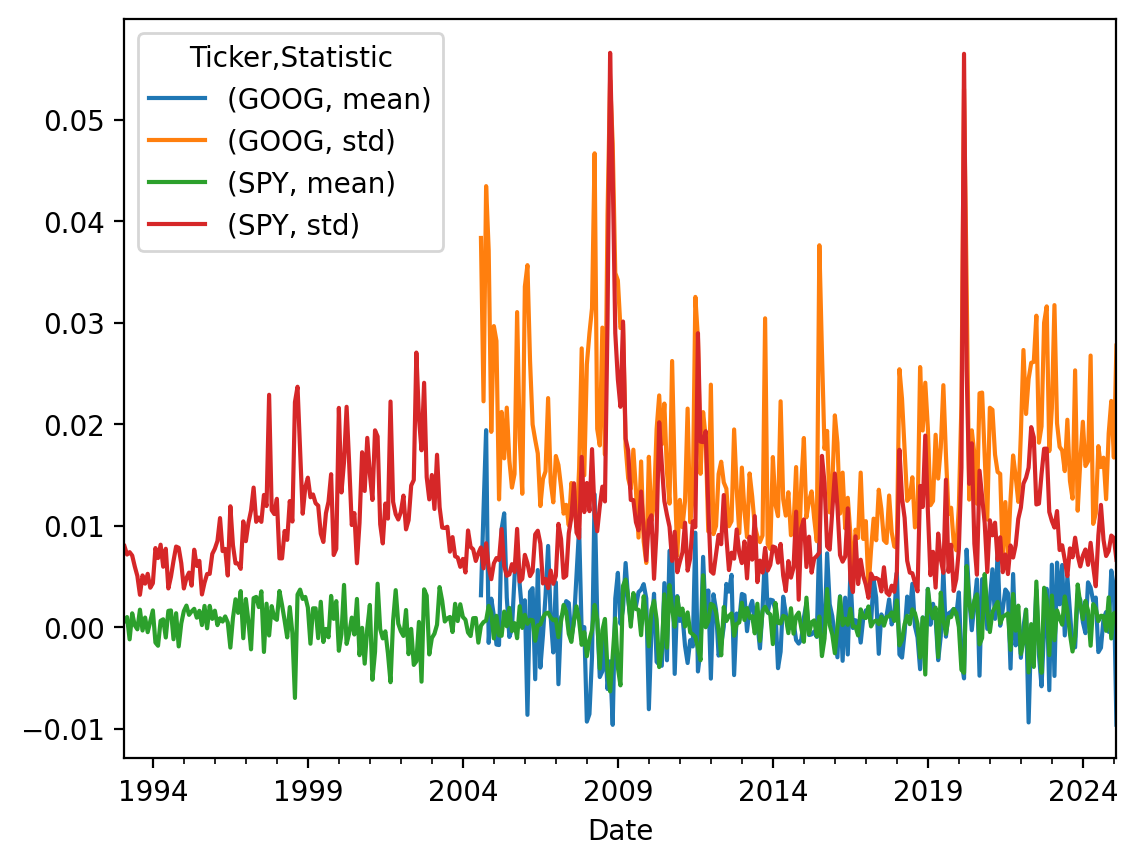

In [23]:
spy_goog_m.plot()

This plot is not very useful because:

1. Mean and volatility are on the same y axis
2. The legend title and labels are cluttered

Let use try the `subplots=True` argument to `.plot()`.

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

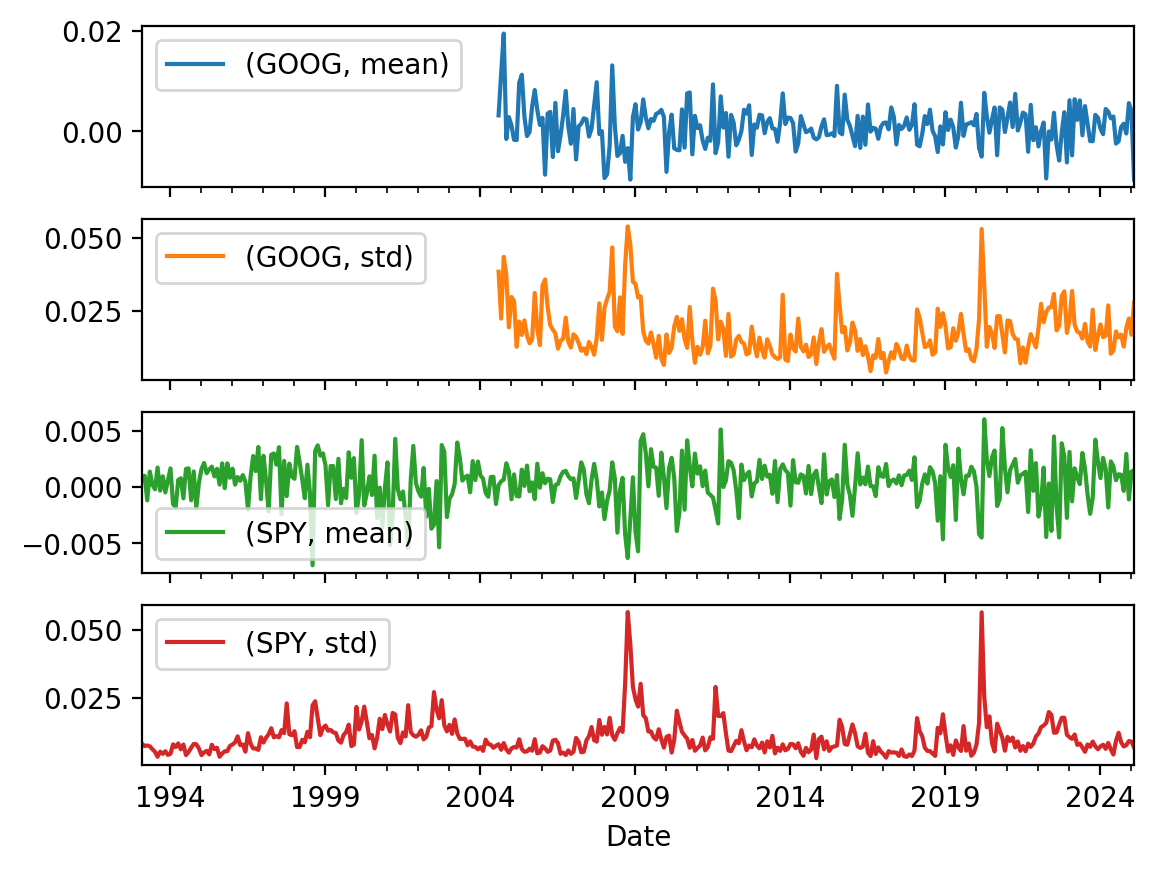

In [24]:
spy_goog_m.plot(subplots=True)

This plot is slightly better, but once I need a more complex plot with different statistics and different individuals, I switch to seaborn.
seaborn is a plotting package built on top of matplotlib and does an excellent job with different statistics and different individuals.
The following example uses `sns.replot()` to plot these four series.
seaborn works best with *all* y values in one column, which we might call and *really* long data frame, and columns instead of indexes.
Please see my comments on the code below.

In [25]:
import seaborn as sns

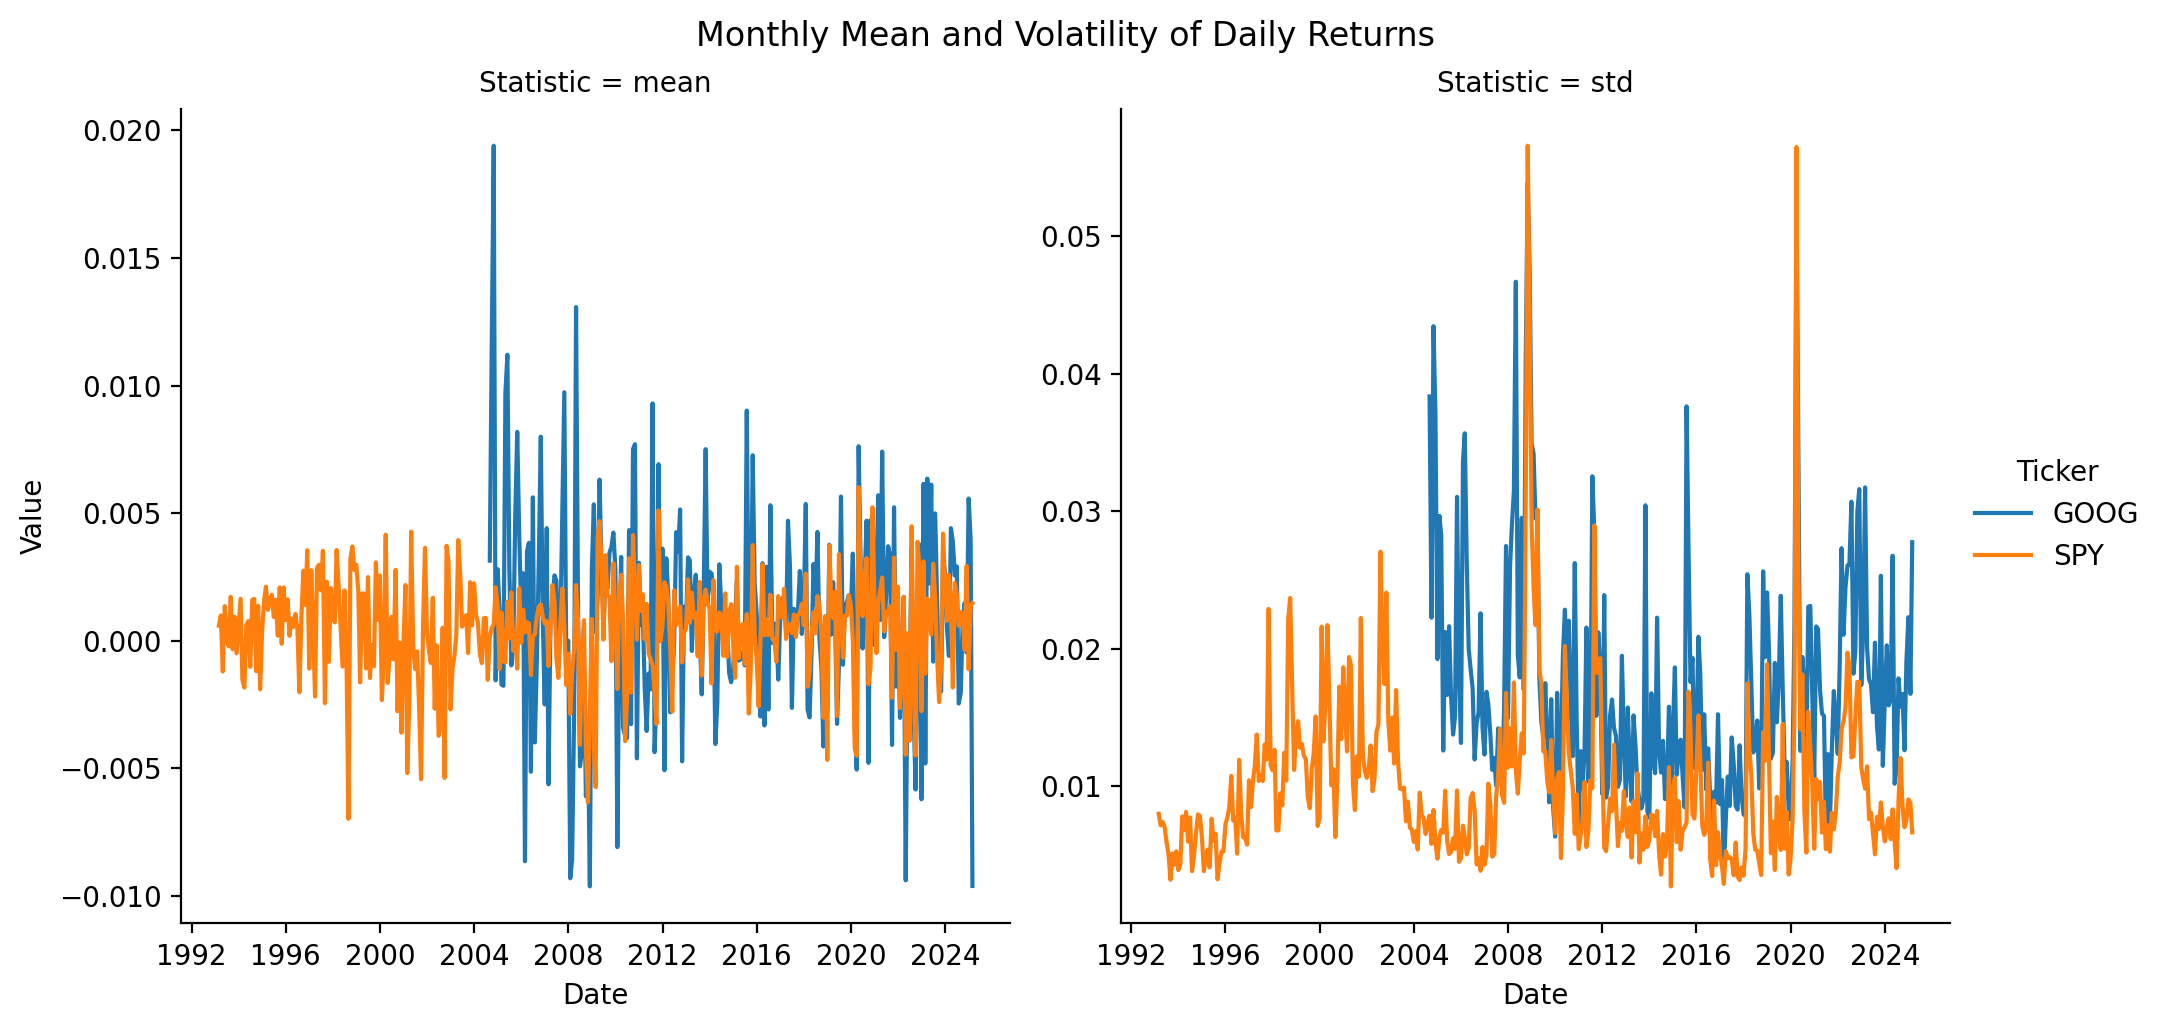

In [26]:
(
    # Start with the 'spy_goog_m' DataFrame that contains monthly volatility and returns for SPY and GOOG
    spy_goog_m
    # Stack the DataFrame once; by default stack will pivot the inner column index into the row index
    .stack(future_stack=True)
    # Stack a second time to fully pivot all remaining columns into the index
    .stack(future_stack=True)
    # Convert the stacked Series into a DataFrame and name the single value column as 'Value'
    .to_frame('Value')
    # Reset the multi-level index so that 'Date', 'Ticker', and 'Statistic' become columns
    .reset_index()
    # Use .pipe() to pass the resulting DataFrame directly into sns.relplot with the following arguments
    .pipe(
        sns.relplot,
        x='Date',          # The x-axis will be the 'Date' column
        y='Value',         # The y-axis will be the 'Value' column (volatility or returns)
        hue='Ticker',      # Different lines/colors for each ticker (SPY vs GOOG)
        col='Statistic',   # Create separate plots (facets) for each statistic (volatility or returns)
        kind='line',       # Plot a line chart
        facet_kws={'sharey': False}  # Allow each facet to have its own y-scale instead of sharing a single scale
    )
)

plt.suptitle('Monthly Mean and Volatility of Daily Returns', y=1.02)
plt.show()

### Assign the Dow Jones stocks to five portfolios based on the *preceding* month's volatility

***This example may make more sense after we cover chapter 11 on time-series tools.
I recently added "preceding" to this example to prevent any look-ahead bias, but it makes this example more challenging.***

First, we download DJIA data from Yahoo! Finance using the current DJIA tickers from Wikipedia.

In [27]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

In [28]:
djia = (
    yf.download(
        tickers=wiki[2]['Symbol'].to_list(),
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

Next, we will calculate daily returns for `djia`.
We have to use our `pd.MultiIndex.from_product()` trick to create a multi-index for the columns.

::: {.callout-tip}

`pd.MultiIndex.from_product()` takes **a list of iterables** (e.g., lists or arrays) and creates all possible combinations of their elements.
This combination is called a *Cartesian product*.
Each unique combination becomes a distinct entry in the resulting multi index.

:::

In [29]:
columns = pd.MultiIndex.from_product([['Return'], djia['Adj Close'].columns])
djia[columns] = djia['Adj Close'].pct_change()

Next, we calculate monthly volatility of daily returns, then assign stocks to portfolios based on these volatilities.
We will keep these portfolio assignment separate from `djia`, for now.
We use the `.apply()` method with `axis=1` to apply `pd.qcut` to every row/month in without writing a for loop.
We can also pass `q=5` and `labels=False` after we give the `pd.qcut` function name.
Here is a simple `pd.qcut()` example.

In [30]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
pd.qcut(
    x=np.arange(10),
    q=5,
    labels=False
)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [32]:
djia_portfolios = (
    djia
    ['Return']                      # Start with 'Return' data
    .dropna()                       # Drop rows with missing values
    .groupby(pd.Grouper(level='Date', freq='ME'))  # Group by month-end
    .std()                          # Compute std dev within each group
    .apply(pd.qcut, q=5, labels=False, axis=1)  # Bin into 5 quantiles
)
columns = pd.MultiIndex.from_product([['Portfolio'], djia['Return'].columns])
djia_portfolios.columns = columns

djia_portfolios.head()

Portfolio                                        ...                \
Ticker          AAPL AMGN AMZN AXP BA CAT CRM CSCO CVX DIS  ... MSFT NKE NVDA   
Date                                                        ...                 
2008-03-31         3    1    3   4  2   0   3    3   0   1  ...    2   4    3   
2008-04-30         3    1    4   3  2   3   4    2   0   1  ...    3   1    4   
2008-05-31         3    1    4   4  2   0   4    3   1   2  ...    2   2    4   
2008-06-30         3    0    4   4  3   0   4    1   1   1  ...    2   4    3   
2008-07-31         2    3    4   4  2   2   2    1   1   1  ...    2   1    4   

                                     
Ticker     PG SHW TRV UNH  V VZ WMT  
Date                                 
2008-03-31  0   2   1   2  4  2   2  
2008-04-30  0   2   2   4  3  1   0  
2008-05-31  0   3   2   3  4  2   1  
2008-06-30  0   2   2   2  3  2   1  
2008-07-31  0   4   3   3  4  0   1  

[5 rows x 30 columns]

Combining the returns and portfolios is the trickiest step because we want to prevent a look-ahead bias.
For example, we do not know that `AAPL` is in portfolio 3 until *March 2008 ends*.
Therefore, `AAPL` cannot be in portfolio 3 until *April 2008*!

In [33]:
djia_w_portfolios = djia.join(djia_portfolios.shift(periods=1, freq='D'))
djia_w_portfolios['Portfolio'] = djia_w_portfolios['Portfolio'].ffill()

### Plot the time-series volatilities of these five portfolios

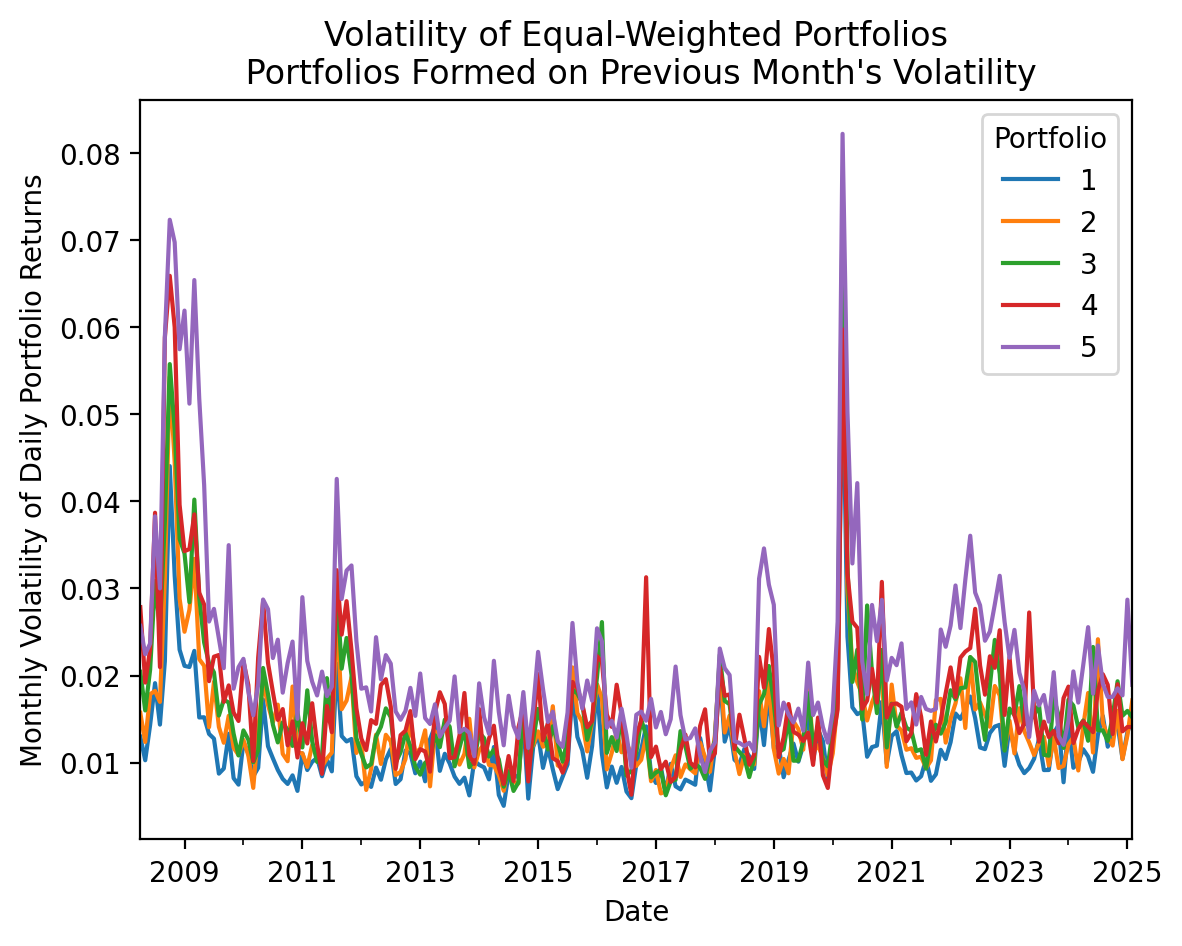

In [34]:
(
    djia_w_portfolios                  # start data frame with portfolio assignments
    .stack(future_stack=True)          # Reshape columns into rows
    .dropna()                          # Remove rows with missing values
    .groupby([pd.Grouper(level='Date', freq='ME'), 'Portfolio'])  # Group by month-end & portfolio
    ['Return']                         # Operate on 'Return'
    .std()                             # Calculate std dev for each group
    .to_frame('Volatility')            # Convert to DataFrame named 'Volatility'
    .reset_index()                     # Make grouped cols into normal columns to fix portfolio colums
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int) + 1)  # Convert portfolio to int & increment
    .set_index(['Date', 'Portfolio'])  # Use 'Date' & 'Portfolio' as new index
    .unstack()['Volatility']           # Reshape wide, focusing on 'Volatility'
    .plot()                            # Generate the plot
)

plt.title('Volatility of Equal-Weighted Portfolios\n Portfolios Formed on Previous Month\'s Volatility')
plt.ylabel('Monthly Volatility of Daily Portfolio Returns')
plt.show()

### Calculate the *mean* monthly correlation between the Dow Jones stocks

We will keep any day with at least 20 stocks.
20 is an arbitrary threshold but provides a 40+ year sample.
The `thresh=20` argument to the `.dropna()` method drops any row with fewer than 20 non-missing values.

In [35]:
djia['Return'].dropna(thresh=20).count(axis=1)

Date
1981-09-23    20
1981-09-24    20
1981-09-25    20
1981-09-28    20
1981-09-29    20
              ..
2025-02-07    30
2025-02-10    30
2025-02-11    30
2025-02-12    30
2025-02-13    30
Length: 10938, dtype: int64

Then we can use the `axis=1` argument to the `.dropna()` to drop any stocks without data.

In [36]:
djia['Return'].dropna(thresh=20).dropna(axis=1).count()

Ticker
AAPL    10938
AXP     10938
BA      10938
CAT     10938
CVX     10938
DIS     10938
HD      10938
HON     10938
IBM     10938
JNJ     10938
JPM     10938
KO      10938
MCD     10938
MMM     10938
MRK     10938
NKE     10938
PG      10938
SHW     10938
TRV     10938
WMT     10938
dtype: int64

Next, we calculate the pairwise correlations between every stock every month.

In [37]:
(
    djia['Return']
    .dropna(thresh=20)
    .dropna(axis=1)
    .groupby(pd.Grouper(level='Date', freq='ME'))
    .corr()
)

Ticker               AAPL     AXP      BA     CAT     CVX     DIS     HD  \
Date       Ticker                                                          
1981-09-30 AAPL    1.0000  0.6520  0.4549  0.5632  0.2316  0.8654    NaN   
           AXP     0.6520  1.0000  0.8350  0.7388  0.4942  0.6656    NaN   
           BA      0.4549  0.8350  1.0000  0.5696  0.8357  0.6053    NaN   
           CAT     0.5632  0.7388  0.5696  1.0000  0.0854  0.2721    NaN   
           CVX     0.2316  0.4942  0.8357  0.0854  1.0000  0.5229    NaN   
...                   ...     ...     ...     ...     ...     ...    ...   
2025-02-28 NKE     0.4558 -0.4177 -0.0791 -0.2625  0.3699  0.0012 0.3779   
           PG     -0.1493  0.4191  0.0098 -0.3788 -0.1903  0.3119 0.0876   
           SHW     0.2362  0.8019  0.1563  0.3900  0.1588 -0.1973 0.7071   
           TRV     0.2719  0.9038  0.3735  0.3700 -0.2171  0.1344 0.3940   
           WMT     0.2012  0.1962  0.4352 -0.1989  0.0728 -0.0659 0.4386   

Ticker                HON     IBM     JNJ     JPM      KO     MCD     MMM  \
Date       Ticker                                                           
1981-09-30 AAPL    0.2991  0.1692 -0.0722 -0.0441  0.8272  0.3541  0.5248   
           AXP     0.7529  0.4243  0.6275 -0.5158  0.8953  0.8155  0.6453   
           BA      0.9685  0.7334  0.7441 -0.5713  0.6188  0.9314  0.4350   
           CAT     0.6127  0.6237  0.1519 -0.5053  0.8419  0.3351  0.0391   
           CVX     0.7683  0.5997  0.7313 -0.5093  0.1715  0.8648  0.3567   
...                   ...     ...     ...     ...     ...     ...     ...   
2025-02-28 NKE     0.7465  0.5196  0.4727 -0.5135  0.2399  0.3841  0.2170   
           PG      0.1379  0.5509  0.2099  0.1853  0.3200 -0.1887 -0.1335   
           SHW     0.1062  0.0801  0.6310  0.3900  0.0842  0.0067  0.5767   
           TRV    -0.2446 -0.0855  0.2955  0.6717 -0.0124 -0.2606  0.4516   
           WMT     0.4663  0.1101  0.2545 -0.2082 -0.3578  0.2285  0.4008   

Ticker                MRK     NKE     PG     SHW     TRV     WMT  
Date       Ticker                                                 
1981-09-30 AAPL    0.6755  0.8195 0.7045  0.7338  0.6740  0.8170  
           AXP     0.8543  0.2044 0.9348  0.8512  0.0686  0.5737  
           BA      0.9594  0.0042 0.7765  0.8539  0.0741  0.1810  
           CAT     0.5817  0.4290 0.5807  0.8574 -0.1149  0.4428  
           CVX     0.8018 -0.2338 0.4587  0.5080  0.1337 -0.1611  
...                   ...     ...    ...     ...     ...     ...  
2025-02-28 NKE    -0.0395  1.0000 0.1898 -0.0491 -0.2581  0.5492  
           PG      0.5286  0.1898 1.0000  0.4443  0.4217  0.2397  
           SHW    -0.0085 -0.0491 0.4443  1.0000  0.8739  0.3708  
           TRV    -0.0263 -0.2581 0.4217  0.8739  1.0000  0.2916  
           WMT    -0.1667  0.5492 0.2397  0.3708  0.2916  1.0000  

[10440 rows x 20 columns]

The hard part is to drop the duplicate and self correlations.
The ssimplest solution is to `.stack()` this data frame, then only keep observations where the first tickers is alphabetically *before* the second ticker.

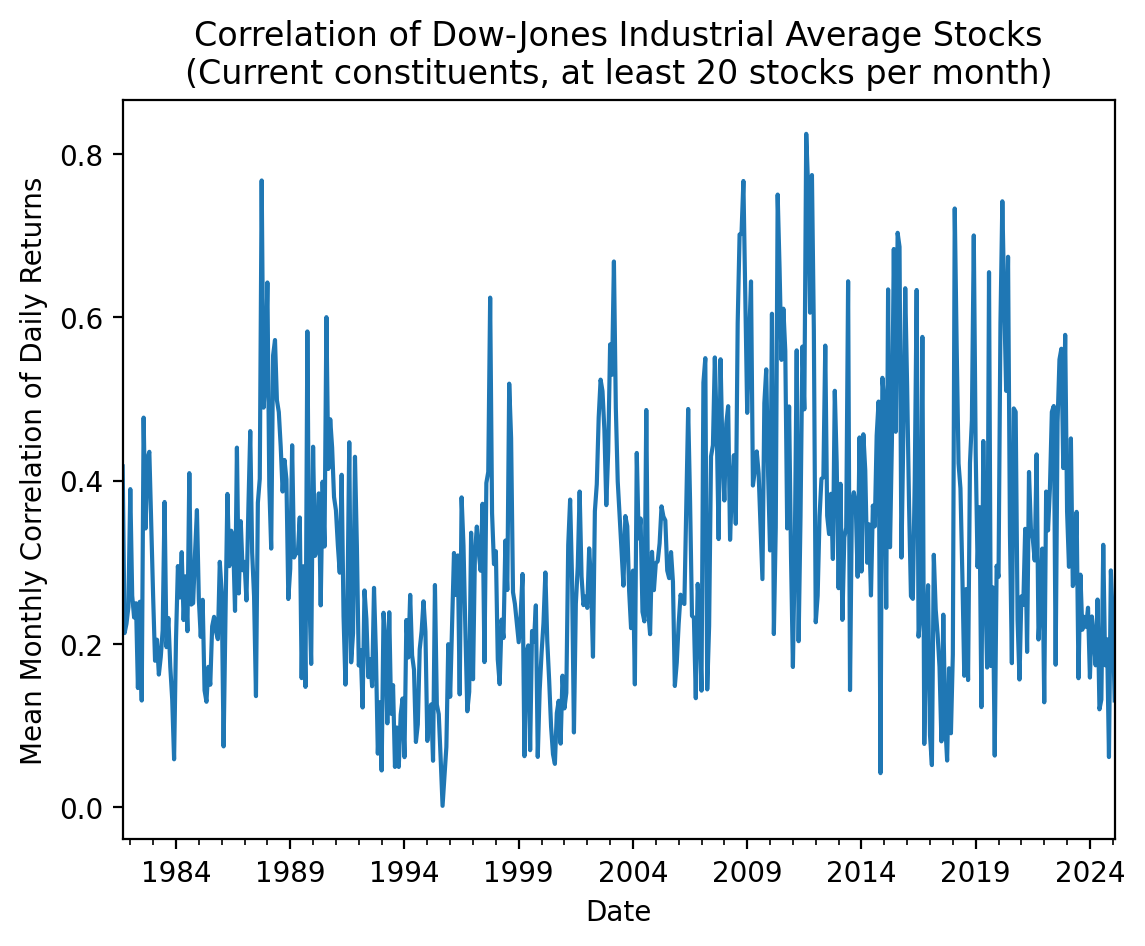

In [38]:
# Calculate correlations for each month-end, then reshape into a long format
djia_correlations = (
    djia['Return']                               # Start with daily returns
    .dropna(thresh=20)                           # Keep rows with at least 20 non-NA tickers
    .dropna(axis=1)                              # Drop any tickers that still have missing values
    .groupby(pd.Grouper(level='Date', freq='ME'))  # Group by end of each month
    .corr()                                      # Calculate correlation matrix for each month
    .stack()                                     # Convert from wide to long format
    .to_frame('Correlation')                     # Name the single column 'Correlation'
)

# Rename index levels for clarity
djia_correlations.index.names = ['Date', 'Ticker1', 'Ticker2']

# Compute mean monthly correlation, excluding the first/last partial months
mean_monthly_corr = (
    djia_correlations
    .iloc[1:-1]                 # Drop the first and last rows (partial months)
    .query('Ticker1 < Ticker2') # Keep only the upper triangle pairs
    .groupby('Date')            # Group by month
    .mean()                     # Average correlation across all ticker pairs
)

# Plot the mean correlation across time
mean_monthly_corr.plot(legend=False)
plt.ylabel('Mean Monthly Correlation of Daily Returns')
plt.title('Correlation of Dow-Jones Industrial Average Stocks\n(Current constituents, at least 20 stocks per month)')
plt.show()


### Is market volatility higher during wars?

Here is some guidance:

1. Download the daily factor data from Ken French's website
1. Calculate daily market returns by summing the market risk premium and risk-free rates (`Mkt-RF` and `RF`, respectively)
1. Calculate the volatility (standard deviation) of daily returns *every month* by combining `pd.Grouper()` and `.groupby()`)
1. Multiply by $\sqrt{252}$ to annualize these volatilities of daily returns
1. Plot these annualized volatilities

Is market volatility higher during wars?
Consider the following dates:

1. WWII: December 1941 to September 1945
1. Korean War: 1950 to 1953
1. Viet Nam War: 1959 to 1975
1. Gulf War: 1990 to 1991
1. War in Afghanistan: 2001 to 2021

In [39]:
pdr.famafrench.get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [40]:
ff = pdr.DataReader(
    name='F-F_Research_Data_Factors_daily',
    data_source='famafrench',
    start='1900'
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_27536\875599436.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(


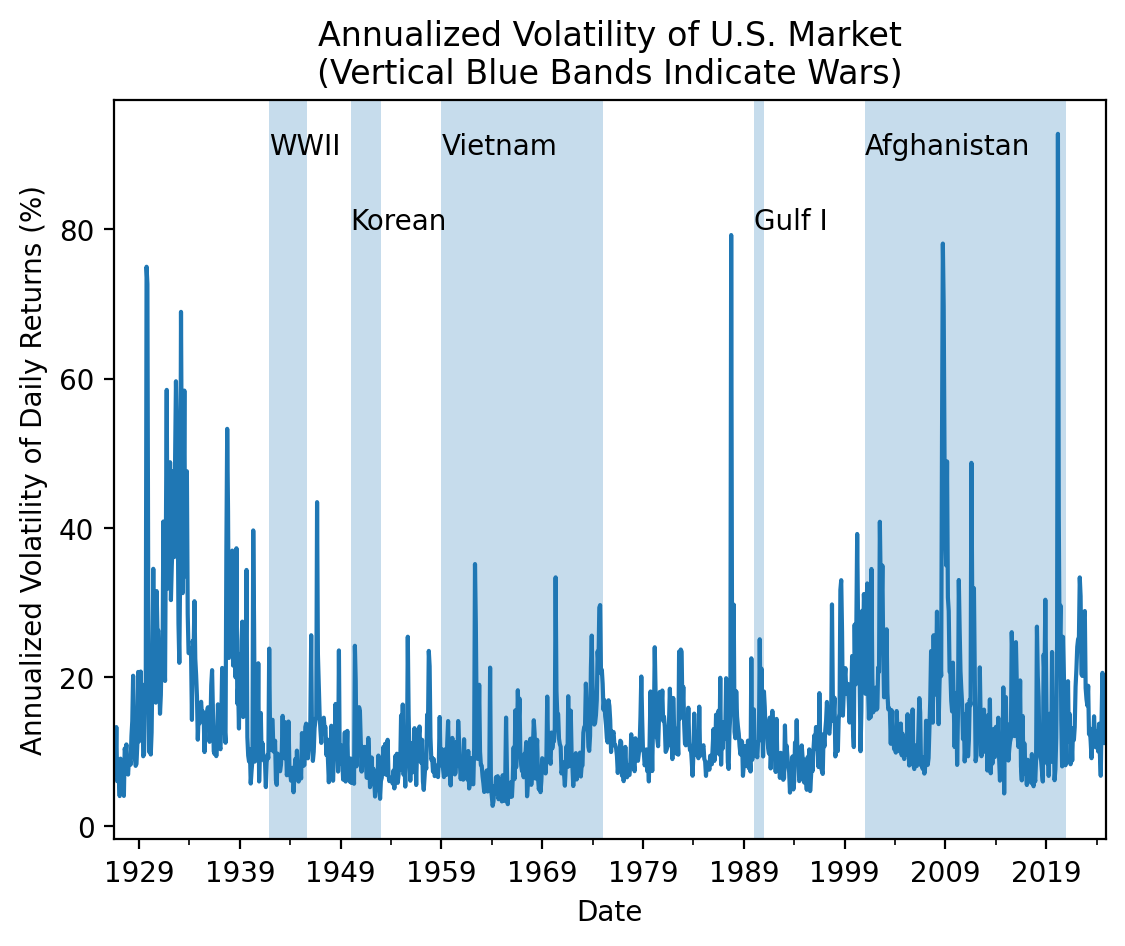

In [41]:
# Calculate and plot the annualized daily volatility of the U.S. market
(
    ff[0]
    .assign(Mkt=lambda df: df['Mkt-RF'] + df['RF'])  # Create 'Mkt' by adding market excess return + risk-free rate
    ['Mkt']                                        # Select only the 'Mkt' column
    .groupby(pd.Grouper(freq='ME'))                # Group by month-end
    .std()                                         # Compute standard deviation within each month
    .mul(np.sqrt(252))                             # Convert to annualized volatility (approx 252 trading days/yr)
    .plot()                                        # Plot the resulting monthly series
)

# Add vertical spans (blue bands) for U.S. wars, with annotation labels
plt.axvspan('1941-12', '1945-09', alpha=0.25)
plt.annotate('WWII', ('1941-12', 90))

plt.axvspan('1950', '1953', alpha=0.25)
plt.annotate('Korean', ('1950', 80))

plt.axvspan('1959', '1975', alpha=0.25)
plt.annotate('Vietnam', ('1959', 90))

plt.axvspan('1990', '1991', alpha=0.25)
plt.annotate('Gulf I', ('1990', 80))

plt.axvspan('2001', '2021', alpha=0.25)
plt.annotate('Afghanistan', ('2001', 90))

# Customize labels and title
plt.ylabel('Annualized Volatility of Daily Returns (%)')
plt.title('Annualized Volatility of U.S. Market\n(Vertical Blue Bands Indicate Wars)')
plt.show()
